## Modeling

(5409526, 43)
(36097, 28)
2000.0 2000000.0
(24076, 23) (12021, 23)
169441 163986
[0]	train-mae:0.78293	valid-mae:0.77706
[499]	train-mae:0.06031	valid-mae:0.07750


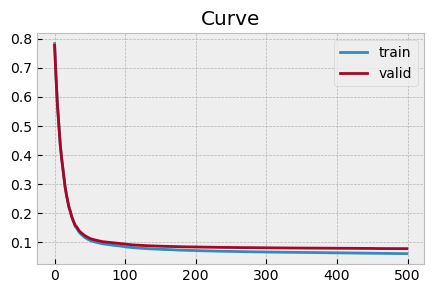

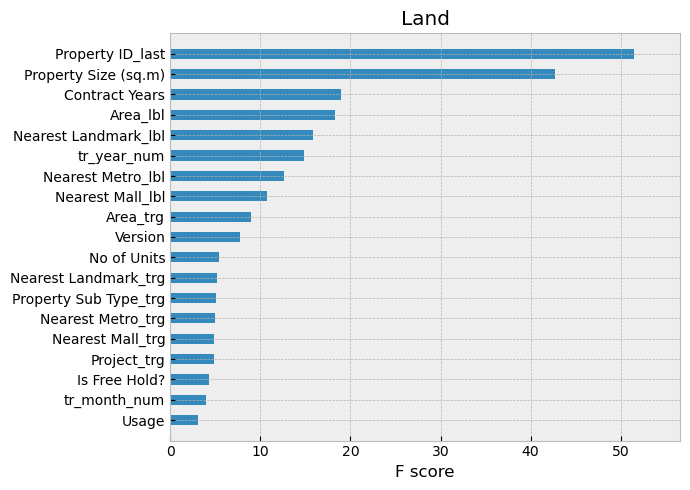

(5409526, 43)
(36097, 28)
(36097, 48)
2000.0 2000000.0
(24076, 43) (12021, 43)
169441 163986
[0]	train-mae:0.74255	valid-mae:0.73602
[499]	train-mae:0.05689	valid-mae:0.07502


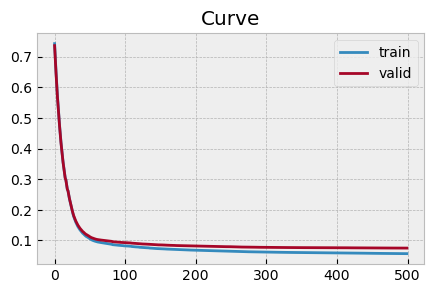

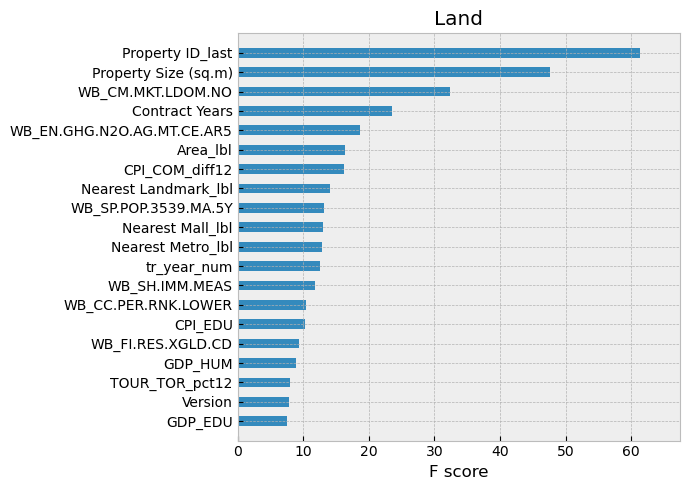

(5409526, 43)
(421395, 28)
10000.0 1000000.0
(280996, 23) (140399, 23)
169331 168626
[0]	train-mae:0.36960	valid-mae:0.36926
[499]	train-mae:0.11806	valid-mae:0.12212


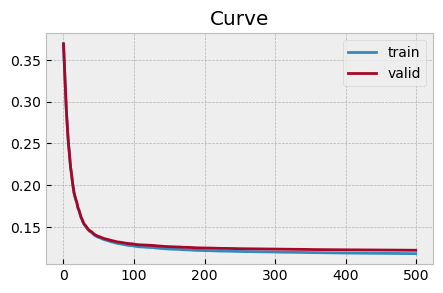

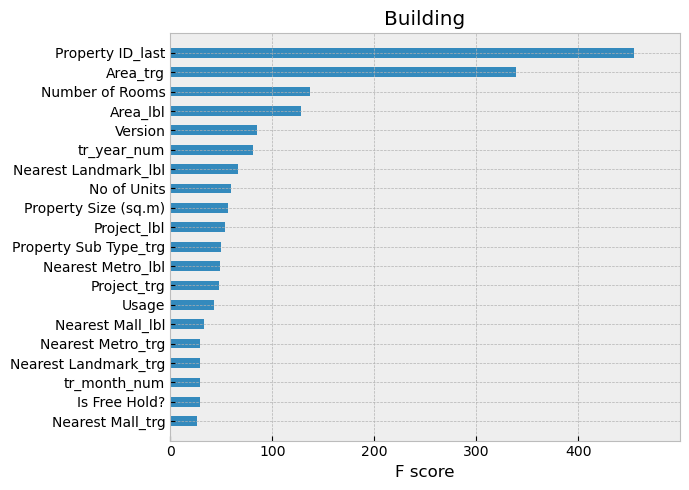

(5409526, 43)
(421395, 28)
(421395, 48)
10000.0 1000000.0
(280996, 43) (140399, 43)
169331 168626
[0]	train-mae:0.36421	valid-mae:0.36375
[499]	train-mae:0.11780	valid-mae:0.12199


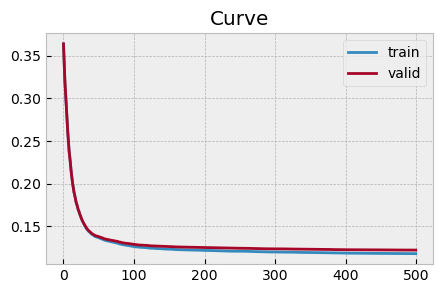

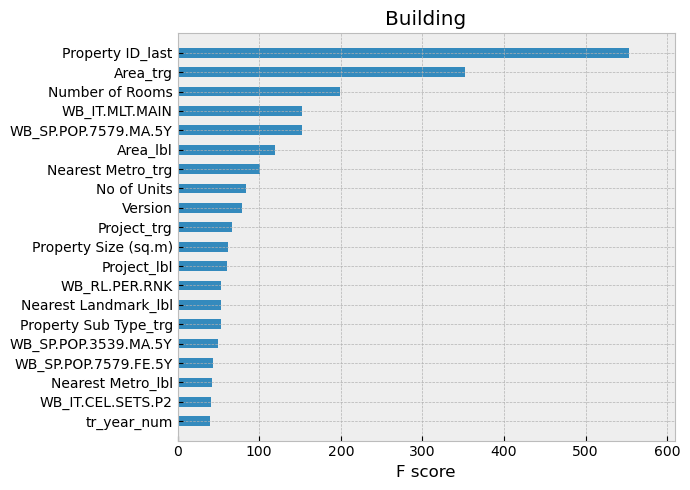

(5409526, 43)
(4904728, 28)
1000.0 1000000.0
(3269767, 23) (1634961, 23)
70892 71044
[0]	train-mae:0.50621	valid-mae:0.50700
[499]	train-mae:0.16700	valid-mae:0.16837


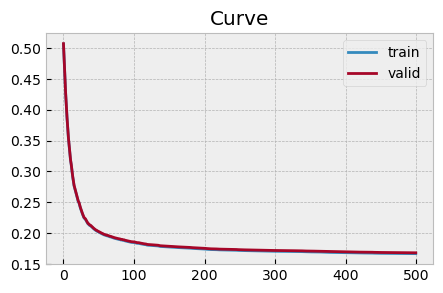

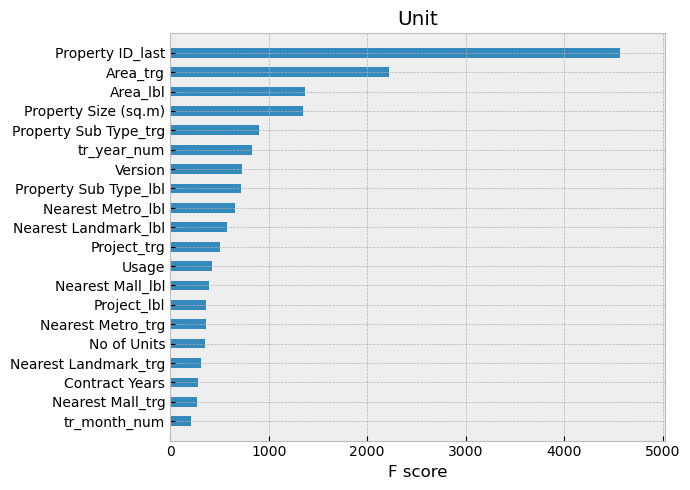

(5409526, 43)
(4904728, 28)
(4904728, 48)
1000.0 1000000.0
(3269767, 43) (1634961, 43)
70892 71044
[0]	train-mae:0.49968	valid-mae:0.50048
[499]	train-mae:0.16594	valid-mae:0.16742


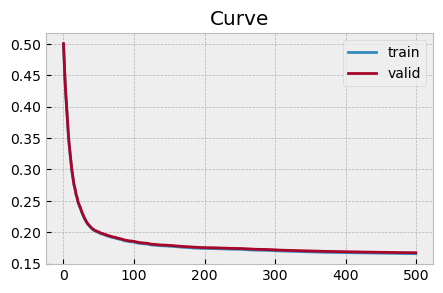

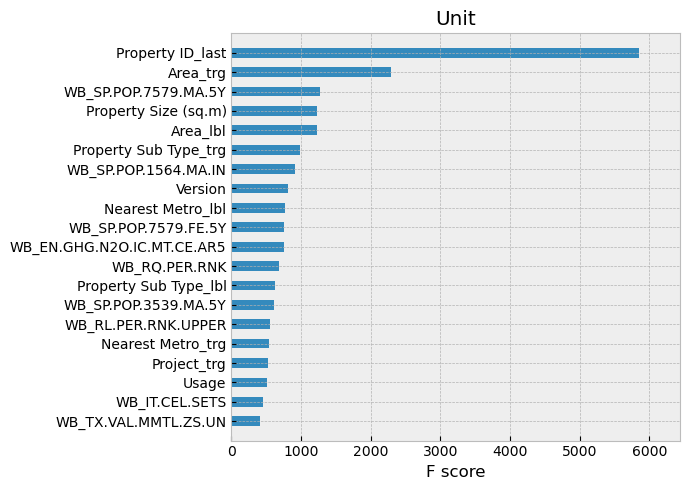

(5409526, 43)
(47306, 28)
1000.0 1000000.0
(31456, 23) (15850, 23)
157969 157120
[0]	train-mae:1.01612	valid-mae:1.01762
[499]	train-mae:0.21281	valid-mae:0.22869


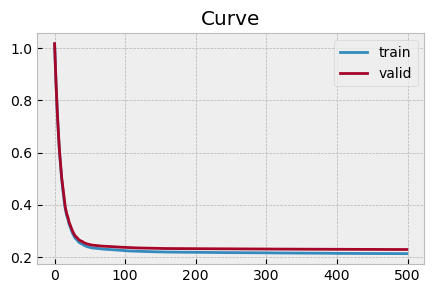

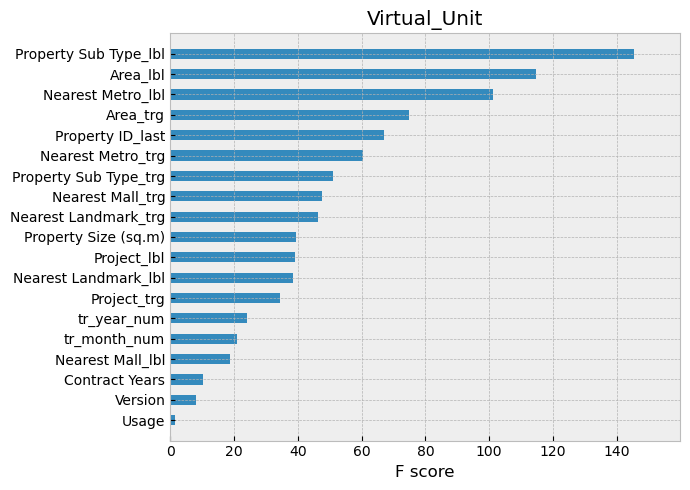

(5409526, 43)
(47306, 28)
(47306, 48)
1000.0 1000000.0
(31456, 43) (15850, 43)
157969 157120
[0]	train-mae:1.01445	valid-mae:1.01591
[499]	train-mae:0.20758	valid-mae:0.22480


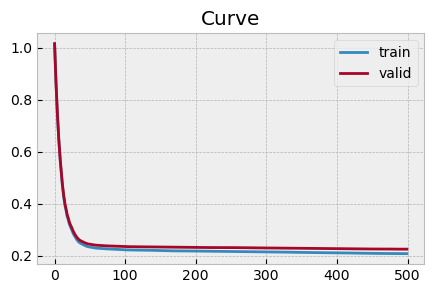

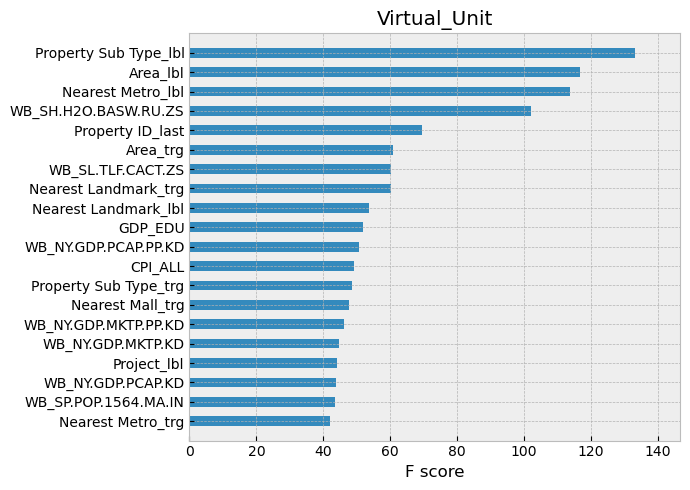

In [1]:
# Main params:
flg_model = 'Building'  # All Land Building Unit Virtual_unit

clip_delta = 0.1  # 0 0.1 0.5 1 5 %
clip_manual = True
clip_drop = False

top_feats = 20 # top additional feats

flg_log = True

flg_cat = True

post = 'rents'

dict_clip = {
    'Building':         [10_000, 1_000_000],
    'Land':             [1_000, 2_000_000],
    'Unit':             [1_000, 1_000_000],
    'Virtual_Unit':     [1_000, 1_000_000], 
}

for flg_model in ['Land','Building','Unit','Virtual_Unit']:
    for top_feats in [0,20]:
        
        if 1:
        
            # read
            df = pd.read_pickle('data2.pkl')
            
            feats = [
                # 'Ejari Contract Number',
                # 'Registration Date',
                # 'Start Date',
                # 'End Date',
                'Property ID',
                'Version',
                # 'Area',
                # 'Contract Amount',
                # 'Annual Amount',
                'Is Free Hold?',
                'Property Size (sq.m)',
                'Property Type',
                # 'Property Sub Type',
                'Number of Rooms',
                'Usage',
                # 'Nearest Metro',
                # 'Nearest Mall',
                # 'Nearest Landmark',
                # 'Parking',
                'No of Units',
                # 'Master Project',
                # 'Project',
                'Contract Years',
                'Amount',
                # 'Transaction Date',
                'dt_month',
                'dt_year',
                'tr_year_num',
                'tr_month_num',
                
                'Property ID_last',
                'Property Type_lbl',
                'Property Sub Type_lbl',
                'Area_lbl',
                'Nearest Metro_lbl',
                'Nearest Mall_lbl',
                'Nearest Landmark_lbl',
                'Project_lbl',
                'Property Sub Type_trg',
                'Area_trg',
                'Nearest Metro_trg',
                'Nearest Mall_trg',
                'Nearest Landmark_trg',
                'Project_trg'
            ]
            
            print(df.shape)
            filt = df['Property Type'] == flg_model if flg_model != 'All' else df.Amount > 0
            df = df[filt][feats].reset_index(drop = True)
            print(df.shape)
        
            # add more data
            if top_feats > 0:
                feats = pd.read_pickle(f'dict_{post}.pkl')[flg_model][:top_feats]
                feats = ['dt_month'] + feats
                df1 = pd.read_pickle('data0.pkl')[feats]
                df = df.merge(df1, on = 'dt_month', how = 'left')
                print(df.shape)
            
            # features define
            feat_target = 'Amount'
            feats_info = [
                'Property ID',
                'Property Type', 
                'Amount', 
                'dt_month',
                'dt_year',
            ]
            feats_used = [f for f in df.columns if f not in feats_info]
            
            feats_cat = [    
                'Property Type',
                'Property Sub Type',
                'Area',
                'Nearest Metro',
                'Nearest Mall',
                'Nearest Landmark',
                'Project',
            ]
            if flg_cat:
                for feat in feats_cat:
                    df[f'{feat}_lbl']  = df[f'{feat}_lbl'].astype("category")
            
            # clipping
            if clip_delta > 0:
                df['lower'] = df.groupby(['Property Type']).Amount.transform(lambda x: np.percentile(x, clip_delta))
                df['upper'] = df.groupby(['Property Type']).Amount.transform(lambda x: np.percentile(x, 100-clip_delta))
                
                if clip_manual:
                    df['lower'] = df['Property Type'].map(lambda x: dict_clip[x][0])
                    df['upper'] = df['Property Type'].map(lambda x: dict_clip[x][1])
                   
                df['is_outlier'] = 0
                df.loc[df.Amount < df.lower, 'is_outlier'] = 1
                df.loc[df.Amount > df.upper, 'is_outlier'] = 1
            
                df.loc[df.Amount < df.lower, 'Amount'] = df.loc[df.Amount < df.lower, 'lower']
                df.loc[df.Amount > df.upper, 'Amount'] = df.loc[df.Amount > df.upper, 'upper']
                
                if clip_drop:
                    f1 = df['is_outlier'] == 0
                    print(df.shape)
                    df = df[f1].reset_index(drop = True)
                    print(df.shape)
            
                del df['lower']
                del df['upper']
                del df['is_outlier']
            
                print(df.Amount.min(), df.Amount.max())
            
            # Sets creation
            import xgboost as xgb
            
            np.random.seed(2017)
            df['fold'] = np.random.randint(0,9,len(df))
            
            filt_train = df.fold > 2
            filt_valid = df.fold.isin([0,1,2])
            filt_test  = df.fold == 0
            
            x, y   = df[filt_train][feats_used], df[filt_train][feat_target]
            xv, yv = df[filt_valid][feats_used], df[filt_valid][feat_target]
            # xt, yt = df[filt_test][feats_used],  df[filt_test][feat_target]
            
            print(x.shape, xv.shape)#, xt.shape)
            print(round(y.mean()),round(yv.mean()))#,round(yt.mean()))
            
            if flg_log:
                y = np.log1p(y)
                yv = np.log1p(yv)
                # yt = np.log1p(yt)
            
            x_ = xgb.DMatrix(x, label=y, enable_categorical=flg_cat)
            xv_ = xgb.DMatrix(xv, label=yv, enable_categorical=flg_cat)
            # xt_ = xgb.DMatrix(xt, label=yt, enable_categorical=flg_cat)
            
            del x,xv
            gc.collect()
            
            # Set params
            params = {
                # Core Parameters
                'objective': 'reg:absoluteerror', # Regression objective
                'eval_metric': 'mae',           # Evaluation metric
                
                # 'binary:logistic':     ['logloss','upd'], # auc
                # 'reg:squarederror':    ['rmse','ret'],
                # 'reg:squaredlogerror': ['rmsle','ret'],
                # 'reg:absoluteerror':   ['mae','ret'],
                # 'reg:quantileerror':   ['mae','ret'],   
                
                # Tree Booster Parameters
                'max_depth': 6,                  # Max tree depth
                'min_child_weight': 1,           # Minimum child weight
                'learning_rate': 0.1,            # Learning rate
                'subsample': 0.8,                # Subsample ratio for rows
                'colsample_bytree': 0.8,         # Subsample ratio for columns per tree
                'colsample_bylevel': 0.8,        # Subsample ratio for columns per level
                'lambda': 1.0,                   # L2 regularization term
                'alpha': 0.0,                    # L1 regularization term
                'gamma': 0.0,                    # Minimum loss reduction for splits
                
                # Boosting Parameters
                # 'num_boost_round': 500,             # Number of trees
                'learning_rate': 0.1,                      # Alias for learning rate
                'scale_pos_weight': 1.0,         # Scale for positive instances
                
                # Miscellaneous Parameters
                'seed': 42,                      # Random seed
                'verbosity': 1,                  # Verbosity level
                'tree_method': 'hist',           # Efficient histogram-based method
                'n_jobs': -1,                    # Parallel threads
            
                'enable_categorical': flg_cat,
                'quantile_alpha': 0.5,
            
            }
            
            
            # train
            evals_results = dict()
                    
            model_xgb = xgb.train(
                params, 
                x_, 
                evals = [
                    (x_, 'train'), 
                    (xv_,'valid'), 
                ], 
                evals_result = evals_results, 
                num_boost_round = 500,
                early_stopping_rounds = 50,
                verbose_eval = 1000
            )
            
            # #.trees_to_dataframe()
            # print(model_xgb.save_config())
            
            # evaluation curve
            ttl = 'Curve'
            df_evals = pd.DataFrame({
                'train': evals_results['train'][params['eval_metric']],
                'valid': evals_results['valid'][params['eval_metric']],
            })
            _ = df_evals.plot(title = ttl, figsize = (5,3))
            
            # feat importance
            _, ax = plt.subplots(figsize=(7,5))
            pars = dict(
                max_num_features=20, 
                height=0.5, 
                importance_type='gain', 
                show_values = False, 
                ylabel = '',
                title = flg_model,
            )
            xgb.plot_importance(model_xgb, ax = ax, **pars)
            plt.tight_layout()
            plt.savefig(f'imgs/imp_{post}_{flg_model}_{top_feats}.png')
            plt.show()
            
            # predictions
            df.loc[filt_train,'pred'] = model_xgb.predict(x_)
            # df.loc[filt_test,'pred'] = model_xgb.predict(xt_)
            df.loc[filt_valid,'pred'] = model_xgb.predict(xv_)
            
            if flg_log:
                df['pred'] = df['pred'].map(np.expm1)
            
            df.loc[filt_train,'subset'] = 'train'
            # df.loc[filt_test,'subset'] = 'test'
            df.loc[filt_valid,'subset'] = 'valid'
            
            feats_add = ['pred','subset']
            df[feats_info + feats_add].to_pickle(f'preds/{post}_{flg_model}_{top_feats}.pkl')